# 1. cleaning the data

## Removing unnecessary fields
### Description
This Python script reads a large JSON Lines (JSONL) file line by line, processes each entry to remove the specified fields, and writes the cleaned data into a new JSONL file. The script is optimized for handling large datasets by processing entries incrementally to avoid memory overload, making it suitable for datasets containing millions of records.

### Features
Field Removal: Removes non-essential fields (images, videos, details, and features) from each entry.
Memory Efficiency: Processes each line independently without loading the entire file into memory.
Scalability: Capable of handling datasets with millions of entries due to its line-by-line processing approach.
Preserves Original Structure: Maintains the integrity of the remaining data fields, ensuring the dataset is ready for subsequent analysis.


In [12]:
import json

# Input and output file paths
input_file = "updated_metadata.jsonl"
output_file = "cleaned_metadata.jsonl"

# Fields to remove
fields_to_remove = ["images", "videos", "details", "features", "bought_together", "description"]

# Process the file
with open(input_file, "r", encoding="utf-8") as infile, open(output_file, "w", encoding="utf-8") as outfile:
    for line in infile:
        entry = json.loads(line.strip())  # Load the JSON object
        # Remove the specified fields
        for field in fields_to_remove:
            entry.pop(field, None)
        # Write the cleaned entry to the output file
        outfile.write(json.dumps(entry) + "\n")

print(f"Cleaned data written to {output_file}")


Cleaned data written to cleaned_metadata.jsonl


## cleaning reviews
Objective:
The purpose of this step is to preprocess the cleaned_metadata.jsonl file by removing unnecessary subfields from the reviews field. This process ensures that only the relevant information for sentiment analysis is retained in the reviews data, making it cleaner and more focused for downstream processing.

Description:
In this step, we focus on cleaning the reviews field within each entry of the cleaned_metadata.jsonl file. Specifically, we remove the following unwanted subfields from each review:

parent_asin
user_id
asin
helpful_vote
These fields are irrelevant for sentiment analysis, as they do not contribute to evaluating the tone or opinion expressed in the review. By removing these fields, we reduce noise in the dataset, streamline the structure, and make it easier to analyze the sentiment of the reviews based on the remaining relevant fields, such as rating, title, text, and timestamp.

In [13]:
import json

# Input and output file paths (same file for input and output)
file_path = "cleaned_metadata.jsonl"

# Fields to remove within the reviews
review_fields_to_remove = ["parent_asin", "user_id", "asin", "helpful_vote", "images"]

# Process the file
with open(file_path, "r", encoding="utf-8") as infile:
    lines = infile.readlines()  # Read all lines into memory

# Modify the data
modified_lines = []
for line in lines:
    entry = json.loads(line.strip())  # Load the JSON object
    
    # Clean the reviews field
    if "reviews" in entry and isinstance(entry["reviews"], list):
        cleaned_reviews = []
        for review in entry["reviews"]:
            # Remove specified fields in each review
            cleaned_review = {k: v for k, v in review.items() if k not in review_fields_to_remove}
            cleaned_reviews.append(cleaned_review)
        entry["reviews"] = cleaned_reviews

    # Prepare the modified entry for output
    modified_lines.append(json.dumps(entry))

# Overwrite the file with the modified data
with open(file_path, "w", encoding="utf-8") as outfile:
    for modified_line in modified_lines:
        outfile.write(modified_line + "\n")

print(f"Reviews cleaned and file {file_path} updated.")

Reviews cleaned and file cleaned_metadata.jsonl updated.


Removing reviews that are not verified purchases. 

In [14]:
import json

# Define the file path
file_path = 'cleaned_metadata.jsonl'

# Read the file, filter the reviews, and write back to the same file
with open(file_path, 'r+') as file:
    lines = file.readlines()  # Read all lines into a list
    file.seek(0)  # Move the file pointer to the beginning
    file.truncate()  # Clear the file content

    # Process each line and filter the reviews
    for line in lines:
        data = json.loads(line)  # Parse the JSON data
        
        # Check if 'reviews' exists, then filter the reviews based on 'verified_purchase'
        if 'reviews' in data:
            # Only keep reviews where 'verified_purchase' is True
            data['reviews'] = [review for review in data['reviews'] if review.get('verified_purchase', False) is True]

        # Write the cleaned data back to the same file
        json.dump(data, file)
        file.write('\n')

print(f"File {file_path} has been updated with filtered reviews.")


File cleaned_metadata.jsonl has been updated with filtered reviews.


## Further cleaning data and feature engineering 

convert dates to suitable format and remove html tags

In [15]:
import pandas as pd
from datetime import datetime
from bs4 import BeautifulSoup

# Load your cleaned data
import json

# Read the cleaned metadata (ensure it's in the proper JSON format for manipulation)
with open("cleaned_metadata.jsonl", "r") as file:
    cleaned_data = [json.loads(line) for line in file]

# Function to convert Unix timestamp to a readable date
def convert_timestamp(timestamp):
    # Convert milliseconds to seconds for datetime conversion
    return datetime.utcfromtimestamp(timestamp / 1000).strftime('%Y-%m-%d %H:%M:%S')

# Function to remove HTML tags from the review text
def remove_html_tags(text):
    return BeautifulSoup(text, "html.parser").get_text()

# Apply the transformations to the data
for entry in cleaned_data:
    # Convert timestamp for each review
    for review in entry.get('reviews', []):
        review['timestamp'] = convert_timestamp(review['timestamp'])
        # Remove HTML tags in the review text
        review['text'] = remove_html_tags(review['text'])

# Save the updated data back to cleaned_metadata.jsonl
with open("cleaned_metadata.jsonl", "w") as file:
    for entry in cleaned_data:
        file.write(json.dumps(entry) + "\n")

print("Timestamp converted and HTML tags removed successfully.")

C:\Users\mitan\AppData\Local\Temp\ipykernel_28984\3263700859.py:15: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  return datetime.utcfromtimestamp(timestamp / 1000).strftime('%Y-%m-%d %H:%M:%S')
C:\Users\mitan\AppData\Local\Temp\ipykernel_28984\3263700859.py:19: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(text, "html.parser").get_text()
C:\Users\mitan\AppData\Local\Temp\ipykernel_28984\3263700859.py:19: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  return BeautifulSoup(text, "html.parser").get_text()


Timestamp converted and HTML tags removed successfully.


## Feature engineering

adding new fields such as review_count and price range

In [16]:
import json

# Function to add Review Count feature
def add_review_count(data):
    for entry in data:
        entry['review_count'] = len(entry.get('reviews', []))  # Count reviews for each product
    return data

# Function to add Price Range feature, handling null prices and converting to numeric
def add_price_range(data):
    for entry in data:
        price = entry.get('price', None)  # Get the price, default to None if not present
        
        # If the price is None or empty, set to 'unknown'
        if price is None or price == '':
            entry['price_range'] = 'unknown'  # Set as 'unknown' if price is missing or empty
        else:
            try:
                # Convert price to float to ensure proper comparison
                price = float(price)
                if price < 10:
                    entry['price_range'] = 'low'
                elif 10 <= price < 30:
                    entry['price_range'] = 'medium'
                else:
                    entry['price_range'] = 'high'
            except ValueError:
                # If conversion fails (e.g., if price is non-numeric), set it as 'unknown'
                entry['price_range'] = 'unknown'
    
    return data

# Load the cleaned data from the cleaned_metadata.jsonl file
with open("cleaned_metadata.jsonl", "r") as file:
    cleaned_data = [json.loads(line) for line in file]

# Apply Review Count and Price Range feature engineering
cleaned_data = add_review_count(cleaned_data)
cleaned_data = add_price_range(cleaned_data)

# Save the updated data with the new features to the same file
with open("cleaned_metadata.jsonl", "w") as file:
    for entry in cleaned_data:
        file.write(json.dumps(entry) + "\n")

print("Review Count and Price Range features added successfully, handling null and non-numeric prices.")

Review Count and Price Range features added successfully, handling null and non-numeric prices.


adding sentiment scores scale -1 to 1 negative to positive, preprocessing text - Lowercasing, Remove Special Characters, Tokenization, Remove Stopwords, Stemming/Lemmatization

In [17]:
import json
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Download NLTK resources (run once)
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize NLP tools
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()
analyzer = SentimentIntensityAnalyzer()

# Function to preprocess text
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove special characters (keep alphanumeric and spaces)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stopwords and apply stemming or lemmatization
    tokens = [lemmatizer.lemmatize(ps.stem(word)) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Function to get sentiment score (VADER)
def get_sentiment_score(text):
    sentiment = analyzer.polarity_scores(text)
    return sentiment['compound']  # Compound score ranges from -1 (negative) to 1 (positive)

# Function to adjust sentiment score based on rating
def adjust_sentiment_based_on_rating(rating, text_sentiment):
    # Normalize rating to scale -1 to 1 (1 is negative, 5 is positive)
    rating_sentiment = 2 * (rating / 5) - 1
    
    # Combine text sentiment and rating sentiment (average them)
    # Adjust the weights depending on how much importance you want to give to the rating vs text
    combined_sentiment = (text_sentiment + rating_sentiment) / 2
    return combined_sentiment

# File path
file_path = 'cleaned_metadata.jsonl'

# Read the file, preprocess the text, and add sentiment scores
with open(file_path, 'r+') as file:
    lines = file.readlines()  # Read all lines into a list
    file.seek(0)  # Move the file pointer to the beginning
    file.truncate()  # Clear the file content

    # Process each line
    for line in lines:
        data = json.loads(line)  # Parse the JSON data

        # Check if 'reviews' exists and process each review
        if 'reviews' in data:
            for review in data['reviews']:
                # Preprocess the review text
                cleaned_text = preprocess_text(review.get('text', ''))
                # Get sentiment score for the review text
                text_sentiment = get_sentiment_score(cleaned_text)
                # Adjust sentiment score based on the rating
                final_sentiment = adjust_sentiment_based_on_rating(review.get('rating', 0), text_sentiment)
                # Add the final sentiment score to the review
                review['sentiment_score'] = final_sentiment

        # Write the updated data back to the same file
        json.dump(data, file)
        file.write('\n')

print(f"File {file_path} has been updated with sentiment scores.")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mitan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mitan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mitan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


File cleaned_metadata.jsonl has been updated with sentiment scores.


Word count of reviews and average of sentiment scores

In [19]:
import json

# Open the JSONL file
file_path = "cleaned_metadata.jsonl"

# Process data line by line
with open(file_path, "r+") as file:
    lines = file.readlines()
    file.seek(0)  # Reset pointer to the start of the file

    for line in lines:
        data = json.loads(line)  # Parse JSON data
        
        # Add word_count for each review
        if "reviews" in data:
            for review in data["reviews"]:
                review["word_count"] = len(review["text"].split())
        
            # Compute average_sentiment_score
            total_sentiment = sum(review["sentiment_score"] for review in data["reviews"])
            data["average_sentiment_score"] = total_sentiment / len(data["reviews"]) if data["reviews"] else 0.0
        else:
            data["average_sentiment_score"] = 0.0  # Default if no reviews
        
        # Write updated JSON data back to file
        file.write(json.dumps(data) + "\n")
    
    file.truncate()  # Remove any leftover data from previous content

count of positive, negative and neutral reviews

In [20]:
import json

# Path to your JSONL file
file_path = "cleaned_metadata.jsonl"

# Temporary list to hold processed data
processed_data = []

# Read the JSONL file line by line
with open(file_path, "r") as infile:
    for line in infile:
        # Parse each line as a JSON object
        data = json.loads(line)
        
        # Initialize counts
        positive_reviews_count = 0
        negative_reviews_count = 0
        neutral_reviews_count = 0
        
        # Process reviews and count sentiment categories
        if "reviews" in data:
            for review in data["reviews"]:
                score = review.get("sentiment_score", 0)
                if score > 0.1:
                    positive_reviews_count += 1
                elif score < -0.1:
                    negative_reviews_count += 1
                else:
                    neutral_reviews_count += 1
        
        # Add counts to the data
        data["positive_reviews_count"] = positive_reviews_count
        data["negative_reviews_count"] = negative_reviews_count
        data["neutral_reviews_count"] = neutral_reviews_count
        
        # Append updated data to the processed list
        processed_data.append(data)

# Optional: Write the updated dataset back to the same file (or print/save as needed)
with open(file_path, "w") as outfile:
    for record in processed_data:
        outfile.write(json.dumps(record) + "\n")

# 2. Exploratory Data Analysis

## 1. General Sentiment Analysis
- Distribution of sentiment scores (mean, median, standard deviation, etc.).
- Proportion of positive, neutral, and negative reviews.
-  common sentiment range (e.g., highly positive, slightly negative).
- Comparison of sentiment scores across product categories or subcategories.


In [8]:
import json
import numpy as np
from collections import defaultdict
from tabulate import tabulate

# File path to the dataset
file_path = "cleaned_metadata.jsonl"

# Sentiment binning for most common sentiment range
sentiment_bins = [-1.0, -0.5, -0.1, 0.1, 0.5, 1.0]  # Binning the sentiment scores
bin_labels = ["Highly Negative", "Negative", "Neutral", "Positive", "Highly Positive"]

# Variables to store overall sentiment analysis
all_sentiment_scores = []
positive_reviews_count = 0
negative_reviews_count = 0
neutral_reviews_count = 0
range_counts = defaultdict(int)
total_reviews = 0

# Reading and processing the data
with open(file_path, 'r') as f:
    lines = f.readlines()
    for line in lines:
        data = json.loads(line)
        total_reviews += data.get('review_count', 0)  # Add total reviews for each product

        for review in data.get('reviews', []):
            score = review['sentiment_score']
            all_sentiment_scores.append(score)
            
            # Count the positive, negative, and neutral reviews
            if score > 0.1:
                positive_reviews_count += 1
            elif score < -0.1:
                negative_reviews_count += 1
            else:
                neutral_reviews_count += 1

            # Bin sentiment score and categorize the review
            bin_index = np.digitize([score], sentiment_bins)[0] - 1
            bin_index = max(0, min(bin_index, len(bin_labels) - 1))  # Ensure the index is within range
            range_counts[bin_labels[bin_index]] += 1

# 1. Distribution of Sentiment Scores
mean_score = np.mean(all_sentiment_scores)
median_score = np.median(all_sentiment_scores)
std_dev_score = np.std(all_sentiment_scores)

# 2. Proportion of Positive, Neutral, and Negative Reviews
positive_percentage = (positive_reviews_count / total_reviews) * 100
negative_percentage = (negative_reviews_count / total_reviews) * 100
neutral_percentage = (neutral_reviews_count / total_reviews) * 100

# 3. Most Common Sentiment Range (using the bin labels)
most_common_range = max(range_counts, key=range_counts.get)

# Displaying the results in a neat, tabular format
print("\n=== Sentiment Distribution ===")
print(f"Total Reviews: {total_reviews}")
print(f"Mean Sentiment Score: {mean_score:.4f}")
print(f"Median Sentiment Score: {median_score:.4f}")
print(f"Standard Deviation of Sentiment Score: {std_dev_score:.4f}")

print("\n=== Proportion of Reviews ===")
print(f"Positive Reviews: {positive_percentage:.2f}%")
print(f"Negative Reviews: {negative_percentage:.2f}%")
print(f"Neutral Reviews: {neutral_percentage:.2f}%")

print("\n=== Most Common Sentiment Range ===")
print(f"The most common sentiment range is: {most_common_range}")

# Display Sentiment Range Distribution
print("\n=== Sentiment Range Distribution ===")
range_table = []
for label in bin_labels:
    range_table.append([label, range_counts[label]])

print(tabulate(range_table, headers=["Sentiment Range", "Count"], tablefmt="fancy_grid", numalign="center"))


=== Sentiment Distribution ===
Total Reviews: 3279585
Mean Sentiment Score: 0.6847
Median Sentiment Score: 0.7881
Standard Deviation of Sentiment Score: 0.2922

=== Proportion of Reviews ===
Positive Reviews: 94.28%
Negative Reviews: 3.11%
Neutral Reviews: 2.62%

=== Most Common Sentiment Range ===
The most common sentiment range is: Highly Positive

=== Sentiment Range Distribution ===
╒═══════════════════╤═════════╕
│ Sentiment Range   │  Count  │
╞═══════════════════╪═════════╡
│ Highly Negative   │  20871  │
├───────────────────┼─────────┤
│ Negative          │  80982  │
├───────────────────┼─────────┤
│ Neutral           │  85832  │
├───────────────────┼─────────┤
│ Positive          │ 293436  │
├───────────────────┼─────────┤
│ Highly Positive   │ 2798464 │
╘═══════════════════╧═════════╛


In [ ]:
import json
import numpy as np
from tabulate import tabulate
from collections import defaultdict

# File path to the large dataset
file_path = 'cleaned_metadata.jsonl'

# Initialize the category sentiment dictionary
category_sentiments = defaultdict(list)

# Function to process data incrementally from a file
def process_large_data(file_path):
    with open(file_path, 'r') as f:
        # Read the file line by line (assuming each line is a separate JSON object)
        for line in f:
            try:
                # Parse each line as a JSON object
                data = json.loads(line)
                
                # Process the sentiment scores for each category in the data
                for review in data.get('reviews', []):
                    sentiment_score = review.get('sentiment_score', 0.0)
                    for category in data.get('categories', []):
                        category_sentiments[category].append(sentiment_score)
            except json.JSONDecodeError:
                # Handle error if the line is not a valid JSON object
                print(f"Skipping invalid line: {line}")

# Function to calculate and display the statistics
def display_statistics():
    category_comparison = []

    # Calculate statistics for each category
    for category, sentiments in category_sentiments.items():
        mean_cat_score = np.mean(sentiments)
        median_cat_score = np.median(sentiments)
        positive_count = sum(1 for score in sentiments if score > 0.1)
        negative_count = sum(1 for score in sentiments if score < -0.1)
        neutral_count = sum(1 for score in sentiments if -0.1 <= score <= 0.1)
        total_count = len(sentiments)

        positive_percentage = (positive_count / total_count) * 100
        negative_percentage = (negative_count / total_count) * 100
        neutral_percentage = (neutral_count / total_count) * 100
        
        category_comparison.append({
            'Category': category,
            'Mean Sentiment': f"{mean_cat_score:.2f}",
            'Median Sentiment': f"{median_cat_score:.2f}",
            'Positive Reviews (%)': positive_percentage,
            'Negative Reviews (%)': negative_percentage,
            'Neutral Reviews (%)': neutral_percentage,
        })

    # Sort and display the top 5 categories with highest positive and negative reviews
    top_positive_categories = sorted(
        [entry for entry in category_comparison if entry['Positive Reviews (%)'] > 0],
        key=lambda x: x['Positive Reviews (%)'], reverse=True
    )[:5]

    top_negative_categories = sorted(
        [entry for entry in category_comparison if entry['Negative Reviews (%)'] > 0],
        key=lambda x: x['Negative Reviews (%)'], reverse=True
    )[:5]

    # Display results without truncation
    print("\n=== Category Comparison (Top 5 Categories with Highest Positive Reviews) ===")
    headers = ['Category', 'Mean Sentiment', 'Median Sentiment', 'Positive Reviews (%)', 'Negative Reviews (%)', 'Neutral Reviews (%)']
    positive_category_table = [list(item.values()) for item in top_positive_categories]
    print(tabulate(positive_category_table, headers=headers, tablefmt="plain", numalign="center"))

    print("\n=== Category Comparison (Top 5 Categories with Highest Negative Reviews) ===")
    negative_category_table = [list(item.values()) for item in top_negative_categories]
    print(tabulate(negative_category_table, headers=headers, tablefmt="plain", numalign="center"))

# Process the data incrementally
process_large_data(file_path)

# Once the data is processed, display the results
display_statistics()


=== Category Comparison (Top 5 Categories with Highest Positive Reviews) ===
Category        Mean Sentiment    Median Sentiment    Positive Reviews (%)    Negative Reviews (%)    Neutral Reviews (%)
Voluntaries          0.7                0.73                  100                      0                       0
Grounds              0.81               0.86                  100                      0                       0
Scottish Folk        0.73               0.81                  100                      0                       0
Zouk                 0.76               0.81                  100                      0                       0
Nicaragua            0.71               0.73                  100                      0                       0

=== Category Comparison (Top 5 Categories with Highest Negative Reviews) ===
Category              Mean Sentiment    Median Sentiment    Positive Reviews (%)    Negative Reviews (%)    Neutral Reviews (%)
Tierra Caliente            0.

## 2. Rating Analysis
- Distribution of ratings (1-5).
- Frequency of each rating score (1-5).
- Proportion of reviews with the highest and lowest ratings.
- Average sentiment score for each rating level.

In [14]:
import json
import pandas as pd
from collections import defaultdict

# Create a dictionary to store counts and sums for the analysis
rating_counts = defaultdict(int)
sentiment_sum = defaultdict(float)

# File path to the JSONL file
file_path = "cleaned_metadata.jsonl"

# Read the file line by line to process it efficiently
with open(file_path, 'r') as file:
    for line in file:
        # Parse each line of the JSONL file
        data = json.loads(line)
        
        # Extract reviews data from each entry
        reviews = data.get('reviews', [])
        
        for review in reviews:
            rating = review.get('rating')
            sentiment_score = review.get('sentiment_score')
            
            # Update rating counts and sentiment sums
            if rating is not None and sentiment_score is not None:
                rating_counts[rating] += 1
                sentiment_sum[rating] += sentiment_score

# 1. Distribution of Ratings (1-5)
print("=== Distribution of Ratings (1-5) ===")
for rating, count in rating_counts.items():
    print(f"Rating {rating}: {count} reviews")

# 2. Frequency of Each Rating Score (1-5)
print("\n=== Frequency of Each Rating Score (1-5) ===")
for rating, count in rating_counts.items():
    print(f"Rating {rating}: {count} reviews")

# 3. Proportion of Reviews with Highest and Lowest Ratings
highest_rating_count = rating_counts.get(5.0, 0)
lowest_rating_count = rating_counts.get(1.0, 0)
total_reviews = sum(rating_counts.values())

highest_rating_proportion = (highest_rating_count / total_reviews) * 100
lowest_rating_proportion = (lowest_rating_count / total_reviews) * 100

print(f"\n=== Proportion of Reviews with Highest and Lowest Ratings ===")
print(f"Proportion of Reviews with Highest Rating (5): {highest_rating_proportion:.2f}%")
print(f"Proportion of Reviews with Lowest Rating (1): {lowest_rating_proportion:.2f}%")

# 4. Average Sentiment Score for Each Rating Level
print("\n=== Average Sentiment Score for Each Rating Level ===")
for rating in rating_counts:
    avg_sentiment = sentiment_sum[rating] / rating_counts[rating]
    print(f"Rating {rating}: {avg_sentiment:.4f}")


=== Distribution of Ratings (1-5) ===
Rating 1.0: 106123 reviews
Rating 5.0: 2554415 reviews
Rating 4.0: 376301 reviews
Rating 3.0: 165893 reviews
Rating 2.0: 76853 reviews

=== Frequency of Each Rating Score (1-5) ===
Rating 1.0: 106123 reviews
Rating 5.0: 2554415 reviews
Rating 4.0: 376301 reviews
Rating 3.0: 165893 reviews
Rating 2.0: 76853 reviews

=== Proportion of Reviews with Highest and Lowest Ratings ===
Proportion of Reviews with Highest Rating (5): 77.89%
Proportion of Reviews with Lowest Rating (1): 3.24%

=== Average Sentiment Score for Each Rating Level ===
Rating 1.0: -0.2435
Rating 5.0: 0.7811
Rating 4.0: 0.5845
Rating 3.0: 0.3174
Rating 2.0: 0.0450


## 3. Review Text Analysis
- Average, median, and maximum word count across all reviews.
- Most common words in positive, negative, and neutral reviews.


In [21]:
import json
import nltk
from collections import Counter
from nltk.corpus import stopwords

# Download NLTK stopwords if not already installed
nltk.download('stopwords')

# Set of stopwords from NLTK
stopwords_set = set(stopwords.words('english'))

# Add custom stopwords relevant to your dataset (optional)
custom_stopwords = {"album", "music", "cd", "track", "song", "The", "this", 
                    "that", "it", "is", "was", "and", "in", "on", "for", "with", 
                    "by", "to", "of", "a", "an", "i", "you", "we", "they", "I", 
                    "the", "It", "This", "this", "CD", "would", "Would", "one", "songs", 
                    "-", "it.", "get", "record", "first", "A", "sound", "even", 
                    "vinyl", "case", "if", "If", "time", "play", "much", "bought", 
                    "got", "original", "album.", "new", "I'm", "music.", "CD.", "two", 
                    "buy", "Very", "2", "disc", "still", "thought", "listen", "really",
                    "many", "back", "could", "came", "received", "sounds", "know",
                    "tracks", "recording", "heard", "It's", "return", "band", "well", 
                    "My", "listening" ,"ordered", "&", "also", "There", "think"}
stopwords_set.update(custom_stopwords)

# Initialize counters and lists
word_counts = []
positive_reviews = []
negative_reviews = []

# File path to the JSONL file
file_path = "cleaned_metadata.jsonl"

# Read the file line by line to process it efficiently
with open(file_path, 'r') as file:
    for line in file:
        # Parse each line of the JSONL file
        data = json.loads(line)
        
        # Extract reviews data from each entry
        reviews = data.get('reviews', [])
        
        for review in reviews:
            text = review.get('text', '')
            sentiment_score = review.get('sentiment_score')
            
            # Clean the review text and filter out stopwords (case-insensitive)
            tokens = [word for word in text.lower().split() if word not in stopwords_set]
            
            # Calculate word count after filtering stopwords
            word_count = len(tokens)
            word_counts.append(word_count)
            
            # Categorize reviews based on sentiment score
            if sentiment_score > 0:
                positive_reviews.append(text)
            elif sentiment_score < 0:
                negative_reviews.append(text)

# 1. Average, Median, and Maximum Word Count Across All Reviews
avg_word_count = sum(word_counts) / len(word_counts)
median_word_count = sorted(word_counts)[len(word_counts) // 2]
max_word_count = max(word_counts)

print("=== Review Text Analysis ===")
print(f"Average Word Count: {avg_word_count:.2f}")
print(f"Median Word Count: {median_word_count}")
print(f"Maximum Word Count: {max_word_count}")

# 2. Most Common Words in Positive, Negative, and Neutral Reviews
def most_common_words(reviews):
    all_words = [word for review in reviews for word in review.split() if word not in stopwords_set]
    word_count = Counter(all_words)
    return word_count.most_common(10)

positive_common_words = most_common_words(positive_reviews)
negative_common_words = most_common_words(negative_reviews)

print("\nMost Common Words in Positive Reviews:")
for word, count in positive_common_words:
    print(f"{word}: {count}")

print("\nMost Common Words in Negative Reviews:")
for word, count in negative_common_words:
    print(f"{word}: {count}")



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mitan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


=== Review Text Analysis ===
Average Word Count: 18.22
Median Word Count: 8
Maximum Word Count: 4249

Most Common Words in Positive Reviews:
great: 564076
like: 495541
love: 421432
good: 377445
Great: 301923
best: 233219
Love: 189600
favorite: 141014
fan: 124158
never: 123481

Most Common Words in Negative Reviews:
like: 18438
quality: 9334
Not: 9160
bad: 8091
disappointed: 8028
good: 7664
never: 4913
poor: 4408
disappointed.: 4239
version: 3965


## 4. Product and Category-Level Analysis
- Average sentiment scores by product.
- Distribution of ratings by product category.
- Most positively and negatively reviewed products.
- Sentiment trends for each main category (e.g., "Digital Music").
- Comparison of review counts and sentiment scores across categories.
- Popular categories for products with high sentiment scores.


In [41]:
import pandas as pd
import json
from prettytable import PrettyTable

# Set Pandas display options to left-align text columns
pd.set_option('display.colheader_justify', 'left')

# Load data from JSONL file
file_path = "cleaned_metadata.jsonl"

# Initialize an empty list to hold all data
data_list = []

# Read the JSONL file line by line
with open(file_path, 'r') as file:
    for line in file:
        data = json.loads(line)
        data_list.append(data)

# Create a DataFrame
reviews_df = pd.DataFrame(data_list)

# Explode the reviews into separate rows
reviews_df = reviews_df.explode('reviews').reset_index(drop=True)

# Ensure non-dictionary values in the 'reviews' column are handled
def extract_field(review, field):
    """Safely extract a field from a review dictionary."""
    if isinstance(review, dict):
        return review.get(field)
    return None

# Extract relevant fields from the exploded reviews
reviews_df['rating'] = reviews_df['reviews'].apply(lambda x: extract_field(x, 'rating'))
reviews_df['sentiment_score'] = reviews_df['reviews'].apply(lambda x: extract_field(x, 'sentiment_score'))
reviews_df['text'] = reviews_df['reviews'].apply(lambda x: extract_field(x, 'text'))
reviews_df['title'] = reviews_df['title']
reviews_df['main_category'] = reviews_df['main_category']

# Drop the exploded reviews column to avoid redundancy
reviews_df = reviews_df.drop(columns=['reviews'])

### **Product and Category-Level Analysis**

# Average Sentiment Scores by Product (Top 5)
avg_sentiment_scores = reviews_df.groupby('title')['sentiment_score'].mean().sort_values(ascending=False).head(5).reset_index()

# Function to display in prettytable format (without borders)
def print_table(title, df):
    print(f"=== {title} ===")
    table = PrettyTable()
    table.field_names = df.columns
    table.border = False  # Remove the border lines
    table.header = True   # Show header
    for row in df.values:
        table.add_row(row)
    print(table)

# Display Average Sentiment Scores by Product
print_table("Average Sentiment Scores by Product (Top 5)", avg_sentiment_scores)
print()  # This prints a new line

# Distribution of Ratings by Product Category (Top Categories)
rating_distribution = reviews_df.groupby('main_category')['rating'].value_counts().unstack(fill_value=0)
top_rating_categories = rating_distribution.loc[rating_distribution.sum(axis=1).nlargest(5).index]
print_table("Distribution of Ratings by Product Category (Top Categories)", top_rating_categories)
print()  # This prints a new line

# Most Positively Reviewed Products (Top 5)
most_positive_products = reviews_df.groupby('title')['sentiment_score'].mean().sort_values(ascending=False).head(5).reset_index()
print_table("Most Positively Reviewed Products (Top 5)", most_positive_products)
print()  # This prints a new line

# Most Negatively Reviewed Products (Top 5)
most_negative_products = reviews_df.groupby('title')['sentiment_score'].mean().sort_values().head(5).reset_index()
print_table("Most Negatively Reviewed Products (Top 5)", most_negative_products)
print()  # This prints a new line

# Sentiment Trends by Main Category (Top 5)
category_sentiment = reviews_df.groupby('main_category')['sentiment_score'].mean().sort_values(ascending=False).head(5).reset_index()
print_table("Sentiment Trends by Main Category (Top 5)", category_sentiment)
print()  # This prints a new line

# Comparison of Review Counts and Sentiment Scores Across Categories (Top 5 by Review Count)
category_stats = reviews_df.groupby('main_category').agg(
    review_count=('title', 'size'),
    avg_sentiment=('sentiment_score', 'mean')
).sort_values(by='review_count', ascending=False).head(5).reset_index()
print_table("Comparison of Review Counts and Sentiment Scores Across Categories (Top 5 by Review Count)", category_stats)
print()  # This prints a new line

# Popular Categories for High Sentiment Scores (Top 5)
high_sentiment_reviews = reviews_df[reviews_df['sentiment_score'] > 0.8]
popular_categories = high_sentiment_reviews.groupby('main_category')['title'].count().sort_values(ascending=False).head(5).reset_index()
print_table("Popular Categories for High Sentiment Scores (Top 5)", popular_categories)
print()  # This prints a new line


=== Average Sentiment Scores by Product (Top 5) ===
                                                          title                                                            sentiment_score 
                                                    La Finta Semplice                                                           0.9999     
                          Classic Columbia and Okeh Benny Goodman Orchestra Sessions (1939-1958)                                0.9999     
 Mozart - La finta giardiniera / Gruberova · T. Moser · Heilmann · Margiono · Bacelli · Upshaw · Scharinger · Harnoncourt      0.99985     
                                                Only Inhuman: Tour Edition                                                     0.99985     
                                            Now Yearbook Extra 1983 / Various                                                   0.9998     

=== Distribution of Ratings by Product Category (Top Categories) ===
  1.0     2.0    3.0     4.0      5.0 

## 5. Price analysis

In [23]:
import json
import numpy as np

# Load the data
data_file = 'cleaned_metadata.jsonl'

# Lists to store product titles and prices
products = []
prices = []

# Price range counters
price_ranges = {
    '0-50': 0,
    '51-100': 0,
    '101-500': 0,
    '501-1000': 0,
    '1000+': 0
}

# Read the data and extract relevant information
with open(data_file, 'r') as f:
    for line in f:
        album = json.loads(line)
        
        # Ensure the album has both title and price attributes
        if 'title' in album and 'price' in album:
            price_str = album['price']
            
            # Handle cases where price is null (None)
            if price_str is None:
                continue  # Skip this entry if the price is null
                
            # If the price is a string, clean it to keep only numeric characters
            if isinstance(price_str, str):
                price = ''.join(filter(str.isdigit, price_str))
                if price:  # Only append if the price is valid
                    price = float(price)
                    products.append({'title': album['title'], 'price': price})
                    prices.append(price)
            elif isinstance(price_str, (int, float)):  # If it's already a number
                price = float(price_str)
                products.append({'title': album['title'], 'price': price})
                prices.append(price)

# Calculate average price (mean of the prices)
if prices:
    average_price = np.mean(prices)
    median_price = np.median(prices)
    std_dev_price = np.std(prices)
    q25, q50, q75 = np.percentile(prices, [25, 50, 75])

    print(f"Average price of all products: ${average_price:.2f}")
    print(f"Median price of all products: ${median_price:.2f}")
    print(f"Standard deviation of prices: ${std_dev_price:.2f}")
    print(f"Price Quantiles (25th, 50th, 75th percentiles): ${q25:.2f}, ${q50:.2f}, ${q75:.2f}")
    
    # Count products in each price range
    for price in prices:
        if 0 <= price <= 50:
            price_ranges['0-50'] += 1
        elif 51 <= price <= 100:
            price_ranges['51-100'] += 1
        elif 101 <= price <= 500:
            price_ranges['101-500'] += 1
        elif 501 <= price <= 1000:
            price_ranges['501-1000'] += 1
        elif price > 1000:
            price_ranges['1000+'] += 1

    # Display the product count in each price range
    print("\nPrice range distribution:")
    for range_label, count in price_ranges.items():
        print(f"{range_label}: {count} products")
    
    # Outlier Detection using IQR
    q1 = np.percentile(prices, 25)
    q3 = np.percentile(prices, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = [price for price in prices if price < lower_bound or price > upper_bound]

    print(f"\nNumber of outliers detected: {len(outliers)}")

    # Display the top 10 most expensive and least expensive products
    sorted_products_highest = sorted(products, key=lambda x: x['price'], reverse=True)
    sorted_products_lowest = sorted(products, key=lambda x: x['price'])

    top_10_highest = sorted_products_highest[:10]
    top_10_lowest = sorted_products_lowest[:10]

    print("\nTop 10 Products with Highest Prices:")
    for product in top_10_highest:
        print(f"{product['title']} - ${product['price']:.2f}")

    print("\nTop 10 Products with Lowest Prices:")
    for product in top_10_lowest:
        print(f"{product['title']} - ${product['price']:.2f}")

else:
    print("No valid products found.")

Average price of all products: $29.80
Median price of all products: $16.98
Standard deviation of prices: $73.27
Price Quantiles (25th, 50th, 75th percentiles): $10.75, $16.98, $29.98

Price range distribution:
0-50: 482809 products
51-100: 46102 products
101-500: 21525 products
501-1000: 583 products
1000+: 245 products

Number of outliers detected: 59136

Top 10 Products with Highest Prices:
Keeper of the Seven Keys - Part 1 - $19995.00
Bright Yellow Moon - $9978.00
Teddy Boys Don't Knit - $9400.00
Paws&tales God with the Wind - $9298.00
5 [SHM-CD] - $8900.00
Let's Pretend: Smithsonian Historical Performances, Radio's Outstanding Children's Theatre [4 Audio CD Set] - $8500.00
Lady in Cement - Original Motion Picture Soundtrack - $8082.00
Violin Concertos: Historic Russian Archives - $7588.00
Tienen Que Saber - $7500.00
Vivaldi: Musique Sacree [Sacred Music] - $7297.00

Top 10 Products with Lowest Prices:
State I'm in - $0.01
Bitter Suite - $0.01
Smooth Hits 2000: Countdown Mix Masters

## 6. Price and Sentiment
- Correlation between product price and sentiment score.
- Comparison of sentiment scores for products in different price ranges.
- Trends in ratings for products in different price ranges.
- Distribution of positive/negative reviews for premium vs. budget products.


In [43]:
import json
import pandas as pd

# Load data from the JSONL file
file_path = "cleaned_metadata.jsonl"

# Initialize an empty list to hold all data
data_list = []

# Read the JSONL file line by line
with open(file_path, 'r') as file:
    for line in file:
        data = json.loads(line)
        data_list.append(data)

# Create a DataFrame from the data
df = pd.DataFrame(data_list)

# Exploding the 'reviews' column to separate reviews into individual rows
df = df.explode('reviews').reset_index(drop=True)

# Ensure non-dictionary values in the 'reviews' column are handled
def extract_field(review, field):
    """Safely extract a field from a review dictionary."""
    if isinstance(review, dict):
        return review.get(field)
    return None

# Extract relevant fields from the 'reviews' column
df['rating'] = df['reviews'].apply(lambda x: extract_field(x, 'rating'))
df['sentiment_score'] = df['reviews'].apply(lambda x: extract_field(x, 'sentiment_score'))
df['text'] = df['reviews'].apply(lambda x: extract_field(x, 'text'))
df['title'] = df['title']
df['main_category'] = df['main_category']
df['price_range'] = df['price_range']  # Assuming price_range is already available in your data

# Drop the 'reviews' column as it's no longer needed
df = df.drop(columns=['reviews'])

### **8. Price and Sentiment Analysis**

# **1. Comparison of sentiment scores for products in different price ranges**
# Calculate the average sentiment score for each price range
price_range_sentiment = df.groupby('price_range')['sentiment_score'].mean().reset_index()
print("\nComparison of Sentiment Scores by Price Range:")
print(price_range_sentiment.to_string(index=False))

# **2. Trends in ratings for products in different price ranges**
# Get the rating distribution for each price range
rating_distribution_by_price = df.groupby('price_range')['rating'].value_counts().unstack(fill_value=0)

# Convert the result to a DataFrame for better formatting and display without additional metadata
print("\nTrends in Ratings by Price Range:")
print(rating_distribution_by_price.to_string())

# **3. Distribution of positive/negative reviews for premium vs. budget products**
# Filter for premium and budget products based on price range
premium_products = df[df['price_range'] == 'high']  # Assuming 'high' represents premium
budget_products = df[df['price_range'] == 'low']   # Assuming 'low' represents budget

# Count the distribution of positive/negative reviews for premium products
premium_sentiment_distribution = premium_products['sentiment_score'].apply(lambda x: 'positive' if x > 0.5 else 'negative').value_counts()
# Convert the result to a DataFrame for cleaner display
premium_sentiment_distribution = premium_sentiment_distribution.reset_index()
premium_sentiment_distribution.columns = ['Sentiment', 'Count']
print("\nDistribution of Positive/Negative Reviews for Premium Products:")
print(premium_sentiment_distribution.to_string(index=False))

# Count the distribution of positive/negative reviews for budget products
budget_sentiment_distribution = budget_products['sentiment_score'].apply(lambda x: 'positive' if x > 0.5 else 'negative').value_counts()
# Convert the result to a DataFrame for cleaner display
budget_sentiment_distribution = budget_sentiment_distribution.reset_index()
budget_sentiment_distribution.columns = ['Sentiment', 'Count']
print("\nDistribution of Positive/Negative Reviews for Budget Products:")
print(budget_sentiment_distribution.to_string(index=False))



Comparison of Sentiment Scores by Price Range:
price_range  sentiment_score
   high     0.68660         
    low     0.68950         
 medium     0.68556         
unknown     0.66803         

Trends in Ratings by Price Range:
rating       1.00000  2.00000  3.00000  4.00000  5.00000
price_range                                             
high         12952     8750    18382     41631    278878
low          22639    18873    42489     97748    644954
medium       54186    39764    86312    196428   1347709
unknown      16346     9466    18710     40494    282874

Distribution of Positive/Negative Reviews for Premium Products:
Sentiment  Count
positive  271105
negative  123065

Distribution of Positive/Negative Reviews for Budget Products:
Sentiment  Count
positive  625855
negative  230988


## Part 3: Data Visualization

### 1. Distribution of Ratings
Visualization: Bar plot or pie chart
Purpose: Show the distribution of the ratings (1.0 to 5.0) across all reviews. This helps to quickly understand how reviews are spread across different ratings.

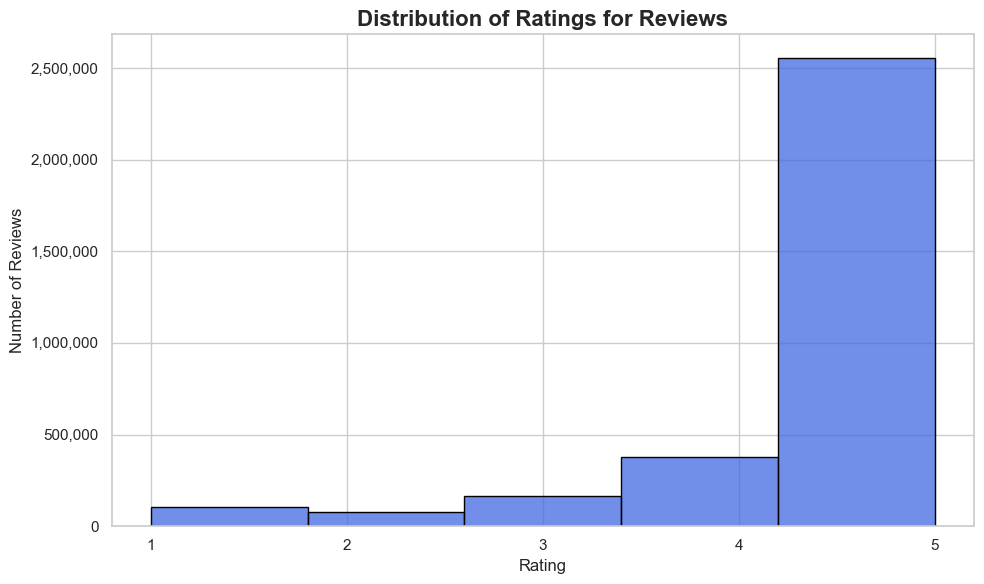

In [46]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Load the data
data_file = 'cleaned_metadata.jsonl'
with open(data_file, 'r') as f:
    data = [json.loads(line) for line in f]

# Extract ratings from reviews, ensuring 'reviews' exists
ratings = []
for album in data:
    if 'reviews' in album:  # Check if 'reviews' exists in the album
        for review in album['reviews']:
            ratings.append(review['rating'])

# Set Seaborn style
sns.set(style="whitegrid", palette="muted")

# Create a plot
plt.figure(figsize=(10, 6))
ax = sns.histplot(ratings, bins=5, kde=False, color='royalblue', edgecolor='black')

# Customizing the title and labels
plt.title('Distribution of Ratings for Reviews', fontsize=16, weight='bold')
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)

# Formatting the y-axis to avoid scientific notation
formatter = FuncFormatter(lambda x, _: f'{int(x):,}')
ax.yaxis.set_major_formatter(formatter)

# Set the ticks on the x-axis for the ratings
plt.xticks([1, 2, 3, 4, 5])

# Show the plot
plt.tight_layout()
plt.show()


### 2. Sentiment Score Distribution
Visualization: Histogram
Purpose: Display the distribution of sentiment scores for all reviews. It can show if most sentiments are positive, negative, or neutral. This can also be used to identify outliers in sentiment analysis.

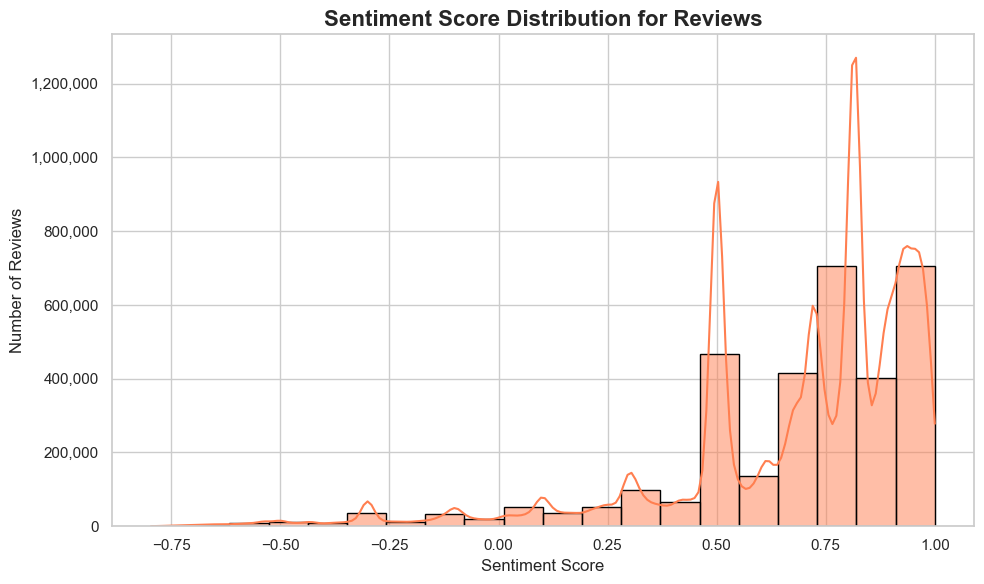

In [47]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Load the data
data_file = 'cleaned_metadata.jsonl'
with open(data_file, 'r') as f:
    data = [json.loads(line) for line in f]

# Extract sentiment scores from reviews, ensuring 'reviews' exists
sentiment_scores = []
for album in data:
    if 'reviews' in album:  # Check if 'reviews' exists in the album
        for review in album['reviews']:
            sentiment_scores.append(review['sentiment_score'])

# Set Seaborn style
sns.set(style="whitegrid", palette="muted")

# Create a histogram of sentiment scores
plt.figure(figsize=(10, 6))
ax = sns.histplot(sentiment_scores, kde=True, bins=20, color='coral', edgecolor='black')

# Customizing the title and labels
plt.title('Sentiment Score Distribution for Reviews', fontsize=16, weight='bold')
plt.xlabel('Sentiment Score', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)

# Formatting the y-axis to avoid scientific notation
formatter = FuncFormatter(lambda x, _: f'{int(x):,}')
ax.yaxis.set_major_formatter(formatter)

# Show the plot
plt.tight_layout()
plt.show()

### 3. Average Rating vs. Sentiment Score
Visualization: heat map
Purpose: Explore the relationship between average rating and sentiment score. Are positive reviews associated with higher ratings? This can uncover correlations between review sentiment and star rating.


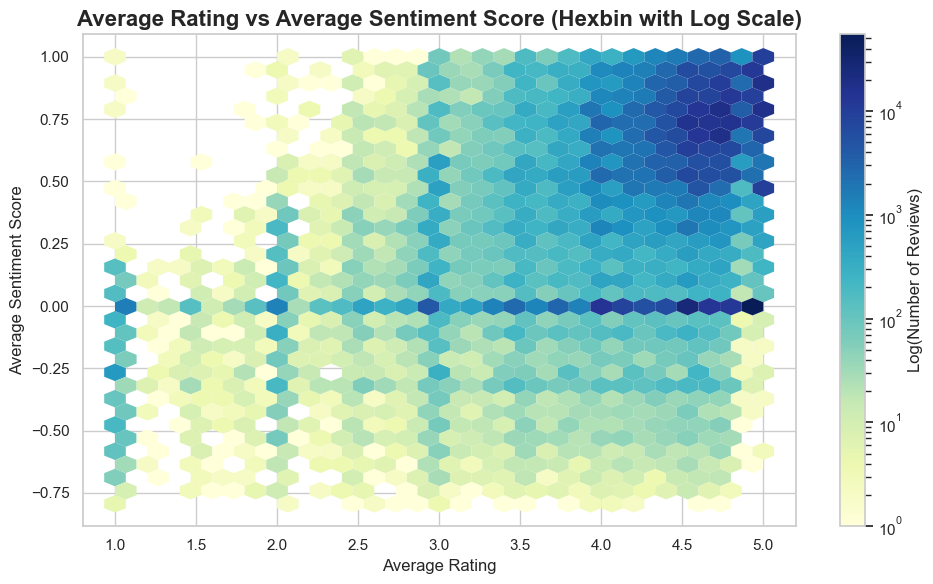

In [53]:
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Load the data
data_file = 'cleaned_metadata.jsonl'

# Pre-allocate lists for average ratings and average sentiment scores
avg_ratings = []
avg_sentiment_scores = []

# Use list comprehension to extract the data more efficiently
with open(data_file, 'r') as f:
    for line in f:
        album = json.loads(line)
        # Extract the average rating and average sentiment score for each album
        avg_ratings.append(album['average_rating'])
        avg_sentiment_scores.append(album['average_sentiment_score'])

# Convert to numpy arrays for faster calculations
avg_ratings = np.array(avg_ratings)
avg_sentiment_scores = np.array(avg_sentiment_scores)

# Set Seaborn style for aesthetics
sns.set(style="whitegrid", palette="muted")

# Create hexbin plot with logarithmic scaling of the color bar
plt.figure(figsize=(10, 6))
hb = plt.hexbin(avg_ratings, avg_sentiment_scores, gridsize=30, cmap='YlGnBu', edgecolors='none', bins='log')

# Add a color bar to indicate the number of reviews with log scale
cb = plt.colorbar(hb)
cb.set_label('Log(Number of Reviews)')

# Customizing the title and labels
plt.title('Average Rating vs Average Sentiment Score (Hexbin with Log Scale)', fontsize=16, weight='bold')
plt.xlabel('Average Rating', fontsize=12)
plt.ylabel('Average Sentiment Score', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


### 4. Sentiment Analysis Breakdown (Positive, Negative, Neutral)
Visualization: pie chart
Purpose: Show the breakdown of the sentiment of reviews (positive, negative, neutral). This can highlight how the general sentiment for the album fares.


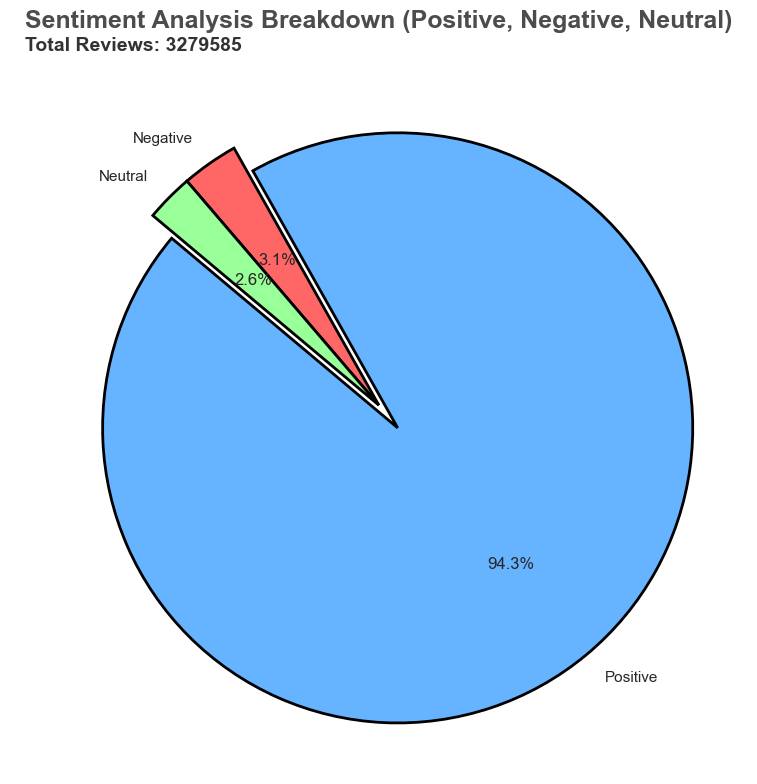

In [60]:
import json
import matplotlib.pyplot as plt

# Load the data
data_file = 'cleaned_metadata.jsonl'

# Initialize counters for sentiment breakdown
positive_count = 0
negative_count = 0
neutral_count = 0

# Iterate over the data and aggregate sentiment counts
with open(data_file, 'r') as f:
    for line in f:
        album = json.loads(line)
        
        # Check if the keys for sentiment counts exist
        if 'positive_reviews_count' in album and 'negative_reviews_count' in album and 'neutral_reviews_count' in album:
            positive_count += album['positive_reviews_count']
            negative_count += album['negative_reviews_count']
            neutral_count += album['neutral_reviews_count']

# Data for the pie chart
labels = ['Positive', 'Negative', 'Neutral']
sizes = [positive_count, negative_count, neutral_count]
colors = ['#66b3ff', '#ff6666', '#99ff99']  # Colors for the segments
explode = (0.1, 0, 0)  # Explode the first slice (Positive) slightly

# Plot the pie chart with clean styling
plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140,
        wedgeprops={'edgecolor': 'black', 'linewidth': 2, 'linestyle': 'solid', 'antialiased': True})

# Customizing the title with a stylish font
plt.title('Sentiment Analysis Breakdown (Positive, Negative, Neutral)', fontsize=18, weight='bold', color='#4c4c4c', fontname='Arial')

# Add a more elegant text annotation for emphasis
plt.text(-1.2, 1.2, f"Total Reviews: {sum(sizes)}", fontsize=14, color='#333333', weight='bold', fontname='Arial')

# Show the plot with tight layout
plt.tight_layout()

# Display the plot
plt.show()


### 5. Word Count vs. Sentiment Score
Visualization: heat map
Purpose: Investigate if there is any relationship between the length of reviews (word count) and the sentiment score. Longer reviews might have more nuanced sentiment.


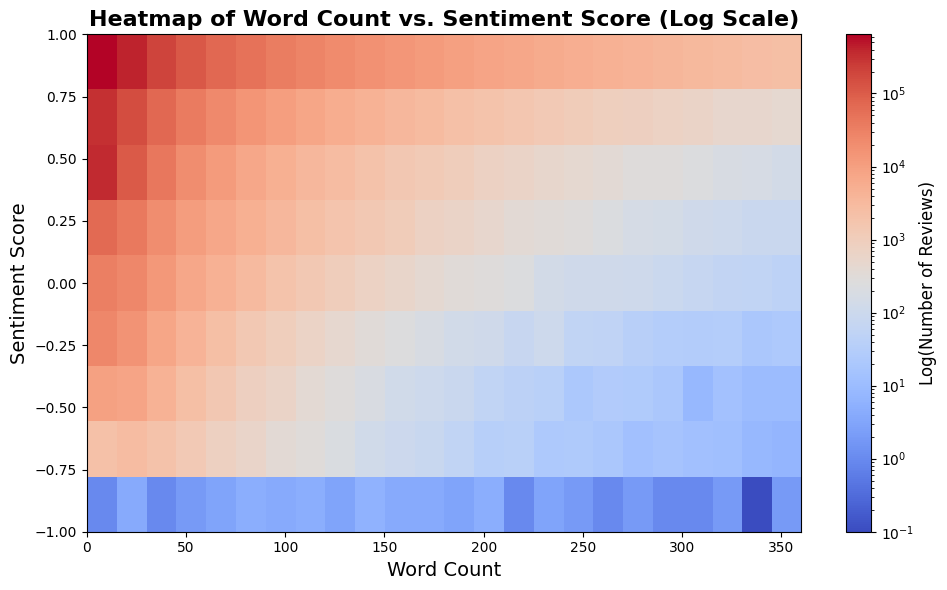

In [50]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Load the data
data_file = 'cleaned_metadata.jsonl'

# Lists for word count and sentiment score
word_counts = []
sentiment_scores = []

# Iterate over the data and collect word count and sentiment score
with open(data_file, 'r') as f:
    for line in f:
        album = json.loads(line)
        for review in album.get('reviews', []):
            word_counts.append(review['word_count'])
            sentiment_scores.append(review['sentiment_score'])

# Convert to NumPy arrays
word_counts = np.array(word_counts)
sentiment_scores = np.array(sentiment_scores)

# Define the range and aggregation bins
max_word_count = int(np.percentile(word_counts, 99))  # Limit to 99th percentile for word counts
min_sentiment, max_sentiment = -1, 1  # Sentiment score range

# Define the bin edges for word count and sentiment
word_bin_edges = np.linspace(0, max_word_count, 25)  # 20 bins for word count
sentiment_bin_edges = np.linspace(min_sentiment, max_sentiment, 10)  # 10 bins for sentiment scores

# Aggregate data by counting the number of reviews in each bin
heatmap, _, _ = np.histogram2d(
    sentiment_scores,
    word_counts,
    bins=[sentiment_bin_edges, word_bin_edges]
)

# Avoid issues with zero by adding a small constant (for log scale)
heatmap = np.where(heatmap == 0, 1e-1, heatmap)

# Plot the heatmap with a logarithmic scale
plt.figure(figsize=(10, 6))
plt.imshow(
    heatmap,
    origin='lower',
    aspect='auto',
    extent=[0, max_word_count, min_sentiment, max_sentiment],
    cmap='coolwarm',
    norm=mcolors.LogNorm(vmin=heatmap.min(), vmax=heatmap.max())  # Logarithmic scale
)

# Add colorbar with log scale
cbar = plt.colorbar()
cbar.set_label('Log(Number of Reviews)', fontsize=12)

# Add title and labels
plt.title('Heatmap of Word Count vs. Sentiment Score (Log Scale)', fontsize=16, weight='bold')
plt.xlabel('Word Count', fontsize=14)
plt.ylabel('Sentiment Score', fontsize=14)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


### 6. Price vs. Average Rating
Visualization: Heat Map
Purpose: Visualize the relationship between the price and the average rating of albums. This is useful if you have data for multiple albums and want to analyze pricing trends.



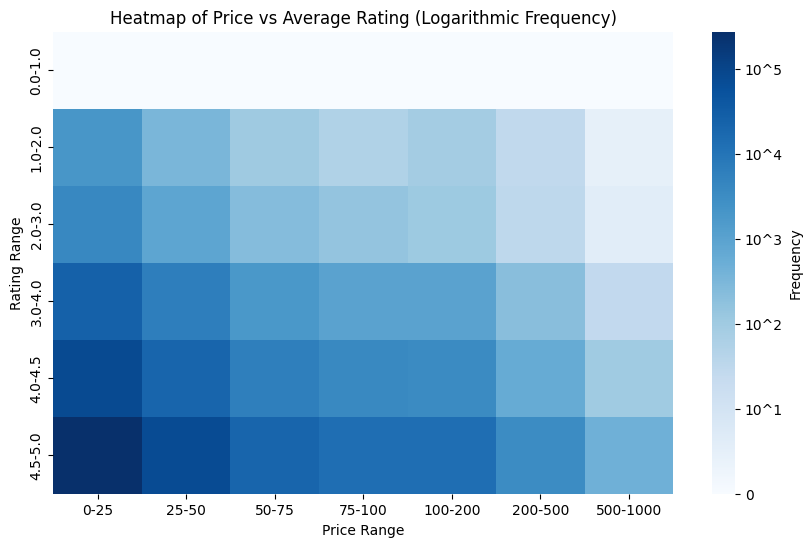

In [64]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# Load the data from the JSONL file
data_file = 'cleaned_metadata.jsonl'

# Lists to store product titles, prices, and average ratings
products = []

# Read the data and extract relevant information
with open(data_file, 'r') as f:
    for line in f:
        album = json.loads(line)
        # Ensure the album has both title, price, and average_rating attributes
        if 'title' in album and 'price' in album and 'average_rating' in album:
            price_str = album['price']
            
            # Handle cases where price is null (None)
            if price_str is None:
                continue  # Skip this entry if the price is null
            
            # If the price is a string, clean it to keep only numeric characters
            if isinstance(price_str, str):
                price = ''.join(filter(str.isdigit, price_str))
                if price:
                    price = float(price)
                else:
                    continue  # Skip invalid prices
            elif isinstance(price_str, (int, float)):
                price = float(price_str)
            
            # Store the valid product, its price, and its average_rating
            products.append({
                'title': album['title'], 
                'price': price, 
                'average_rating': album['average_rating']
            })

# Create a DataFrame from the products list
df = pd.DataFrame(products)

# Convert to numeric, set invalid values to NaN
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Drop rows with NaN values in 'price' or 'average_rating'
df = df.dropna(subset=['price', 'average_rating'])

# Exclude prices above 1000
df = df[df['price'] <= 1000]

# Define the price and rating bins
price_bins = [0, 25, 50, 75, 100, 200, 500, 1000]
rating_bins = [0, 1, 2, 3, 4, 4.5, 5]

# Create a 2D histogram for the heatmap
heatmap_data, xedges, yedges = np.histogram2d(df['price'], df['average_rating'], bins=[price_bins, rating_bins])

# Take log of the frequency, adding a small constant to handle zero values
log_heatmap_data = np.log10(heatmap_data.T + 1)

# Create the heatmap
plt.figure(figsize=(10, 6))

# Custom formatter for the colorbar to show 10^n
def log_fmt(x, pos):
    return f'10^{int(x)}' if x > 0 else '0'

# Create the heatmap
ax = sns.heatmap(
    log_heatmap_data, 
    xticklabels=[f'{x1}-{x2}' for x1, x2 in zip(xedges[:-1], xedges[1:])], 
    yticklabels=[f'{y1}-{y2}' for y1, y2 in zip(yedges[:-1], yedges[1:])], 
    cmap='Blues', 
    cbar_kws={
        'label': 'Frequency',
        'format': ticker.FuncFormatter(log_fmt)
    }
)

plt.xlabel('Price Range')
plt.ylabel('Rating Range')
plt.title('Heatmap of Price vs Average Rating (Logarithmic Frequency)')
plt.show()